#  News Topic Clustering with Transformer Embeddings


Pretrained Transformer models generate dense vector embeddings that capture semantic structure in text. This study explores how news topics are encoded in such embeddings using the AG News dataset, showing that semantically similar headlines cluster naturally in representation space.

To audit topic separability in language model embeddings, the following techniques were applied:

* Pretrained Transformer embeddings (**all-MiniLM-L6-v2** VS **BERT-base-uncased** VS **RoBERTa-base**)

* Principal Component Analysis (PCA)

* T-Distributed Stochastic Neighbor Embedding (t-SNE)

* Logistic Regression (linear probe)


## 0. Set-up


---

In [ ]:
# Use GPU
DEVICE = "cuda"
print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
pip install umap-learn

## 1. Data loading and preprocessing


---

In [ ]:
# Import library
import matplotlib.pyplot as plt
import os, random, math
import pandas as pd
import numpy as np
import torch

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score, f1_score,classification_report
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [ ]:
ds = load_dataset("ag_news")

N_TRAIN = 120000
N_TEST = 7600

train_ds = ds["train"].shuffle(seed=SEED).select(range(N_TRAIN))
test_ds  = ds["test"].shuffle(seed=SEED).select(range(N_TEST))

label_names = ["World", "Sports", "Business", "Sci/Tech"]

In [ ]:
# Check random few examples
for i in range(3):
    print(f"[{label_names[train_ds[i]['label']]}] {train_ds[i]['text']}\n")

[World] Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.

[Sports] Desiring Stability Redskins coach Joe Gibbs expects few major personnel changes in the offseason and wants to instill a culture of stability in Washington.

[World] Will Putin #39;s Power Play Make Russia Safer? Outwardly, Russia has not changed since the barrage of terrorist attacks that culminated in the school massacre in Beslan on Sept.



In [ ]:
# Distribution of labels in your sample
print("Train label counts:", Counter(train_ds['label']))
print("Test  label counts:", Counter(test_ds['label']))

Train label counts: Counter({0: 30000, 1: 30000, 3: 30000, 2: 30000})
Test  label counts: Counter({1: 1900, 2: 1900, 3: 1900, 0: 1900})


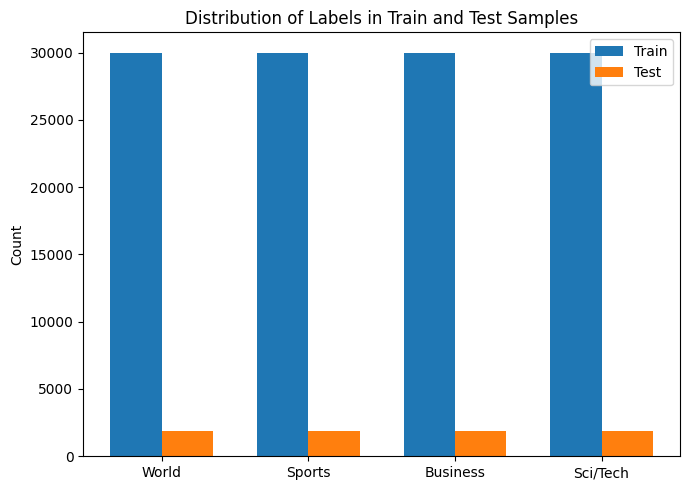

In [ ]:
label_names = ["World", "Sports", "Business", "Sci/Tech"]

# Map numeric labels to text labels
train_labels_text = [label_names[i] for i in train_ds['label']]
test_labels_text = [label_names[i] for i in test_ds['label']]

# Count by text label
train_counts = Counter(train_labels_text)
test_counts = Counter(test_labels_text)

# Ensure consistent order
train_vals = [train_counts.get(name, 0) for name in label_names]
test_vals = [test_counts.get(name, 0) for name in label_names]

x = range(len(label_names))
width = 0.35

plt.figure(figsize=(7, 5))
plt.bar([i - width/2 for i in x], train_vals, width, label="Train")
plt.bar([i + width/2 for i in x], test_vals, width, label="Test")

plt.xticks(x, label_names)
plt.ylabel("Count")
plt.title("Distribution of Labels in Train and Test Samples")
plt.legend()
plt.tight_layout()
plt.show()


## 2. Word Embedding using Pretrained-Transformer

---

In [ ]:
label_names = ["World", "Sports", "Business", "Sci/Tech"]


def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # last_hidden_state
    mask = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    summed = (token_embeddings * mask).sum(dim=1)
    counts = mask.sum(dim=1).clamp(min=1e-9)
    return summed / counts

# Core Functions
def build_hf_model(model_name: str):
    """Load tokenizer+model on the correct DEVICE (once per model)."""
    tok = AutoTokenizer.from_pretrained(model_name)
    mdl = AutoModel.from_pretrained(model_name).to(DEVICE)
    mdl.eval()
    return tok, mdl

@torch.no_grad()
def encode_texts_batched(tokenizer, model, texts, batch_size=64, max_length=128):
    """Encode a list of texts to L2-normalized sentence embeddings."""
    embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=max_length)
        enc = {k: v.to(DEVICE) for k, v in enc.items()}
        out = model(**enc)
        sent = mean_pooling(out, enc["attention_mask"])
        sent = torch.nn.functional.normalize(sent, p=2, dim=1)
        embs.append(sent.cpu().numpy())
    return np.vstack(embs)

## 3. Linear Probe

---

LogisticRegression & LinearSVM & RidgeClassifier

In [ ]:
def fit_best_linear_probe(X_train, y_train, X_test, y_test):
    """Train 3 linear probes; return best by F1-macro + scores dict."""
    probes = {
        "LogisticRegression": LogisticRegression(
            multi_class="multinomial", solver="lbfgs", max_iter=4000, n_jobs=-1, random_state=SEED
        ),
        "LinearSVM": LinearSVC(random_state=SEED),
        "RidgeClassifier": RidgeClassifier(random_state=SEED),
    }
    best_name, best_scores = None, {"acc": -1, "f1_macro": -1}
    per_model = {}
    for name, clf in probes.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1m = f1_score(y_test, y_pred, average="macro")
        per_model[name] = {"acc": acc, "f1_macro": f1m}
        if f1m > best_scores["f1_macro"]:
            best_name, best_scores = name, {"acc": acc, "f1_macro": f1m}
    return best_name, best_scores, per_model

## 4. Dimensionality Reduction

---

First, reduce the 384-dimensional vectors to 50 dimensions using PCA, and then apply t-SNE to project them into a 2-dimensional space for visualisation.

In [ ]:
def tsne_plot_2d(X, y, label_names, title, outpath=None, seed=SEED, sub_n=1000):
    """PCA(50)->t-SNE(2D) and plot; optional save."""
    idx = np.random.choice(len(X), size=min(sub_n, len(X)), replace=False)
    X_sub, y_sub = X[idx], y[idx]
    X_pca = PCA(n_components=50, random_state=seed).fit_transform(X_sub)
    X_2d  = TSNE(n_components=2, perplexity=30, init="pca", learning_rate="auto",
                 random_state=seed).fit_transform(X_pca)

    plt.figure(figsize=(8, 6))
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
    for lab_i, name_i, col in zip(range(len(label_names)), label_names, colors):
        mask = (y_sub == lab_i)
        plt.scatter(X_2d[mask, 0], X_2d[mask, 1], s=12, alpha=0.7, label=name_i, c=col)
    plt.title(title)
    plt.xlabel("dim-1"); plt.ylabel("dim-2"); plt.legend(); plt.tight_layout()
    if outpath:
        os.makedirs(os.path.dirname(outpath), exist_ok=True)
        plt.savefig(outpath, dpi=200)
    plt.show()

## 5. Evaluation Pipelines

---


In [ ]:
def run_one_model(model_label, model_name, X_train_texts, y_train, X_test_texts, y_test,
                  save_dir="figs", sub_n_tsne=1000):
    """Encode with a HF model, pick best probe, plot/save t-SNE. Returns a summary row."""
    print(f"\n=== {model_label} ({model_name}) ===")
    tok, mdl = build_hf_model(model_name)

    # Encode
    X_train_emb = encode_texts_batched(tok, mdl, X_train_texts)
    X_test_emb  = encode_texts_batched(tok, mdl, X_test_texts)

    # Best linear probe
    best_name, best_scores, _ = fit_best_linear_probe(X_train_emb, y_train, X_test_emb, y_test)
    print(f"Best probe: {best_name} | F1-macro={best_scores['f1_macro']:.4f} | Acc={best_scores['acc']:.4f}")

    # t-SNE visualisation per model
    title = f"{model_label} embeddings \nBest probe: {best_name} | F1={best_scores['f1_macro']:.3f}"
    outpath = os.path.join(save_dir, f"tsne_{model_label.replace(' ','_').lower()}.png")
    tsne_plot_2d(X_train_emb, y_train, label_names, title, outpath=outpath, sub_n=sub_n_tsne)

    # Return a compact summary row
    return {
        "Model": model_label,
        "Best_Probe": best_name,
        "Test_Acc": best_scores["acc"],
        "Test_F1_macro": best_scores["f1_macro"],
        "Emb_Dim": X_train_emb.shape[1],
        "Train_N": X_train_emb.shape[0],
        "Test_N": X_test_emb.shape[0],
    }

## 6. Run the code

---
Use three transformer based models:

* all-MiniLM-L6-v2
* BERT-base
* RoBERTa-base


=== MiniLM (sentence-transformers/all-MiniLM-L6-v2) ===


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best probe: LinearSVM | F1-macro=0.8956 | Acc=0.8958


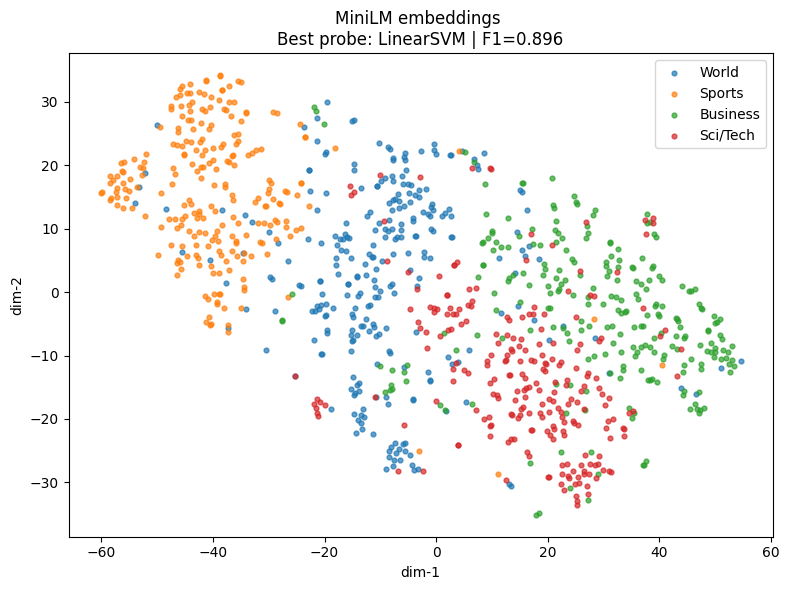


=== BERT-base (bert-base-uncased) ===


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best probe: LinearSVM | F1-macro=0.9118 | Acc=0.9120


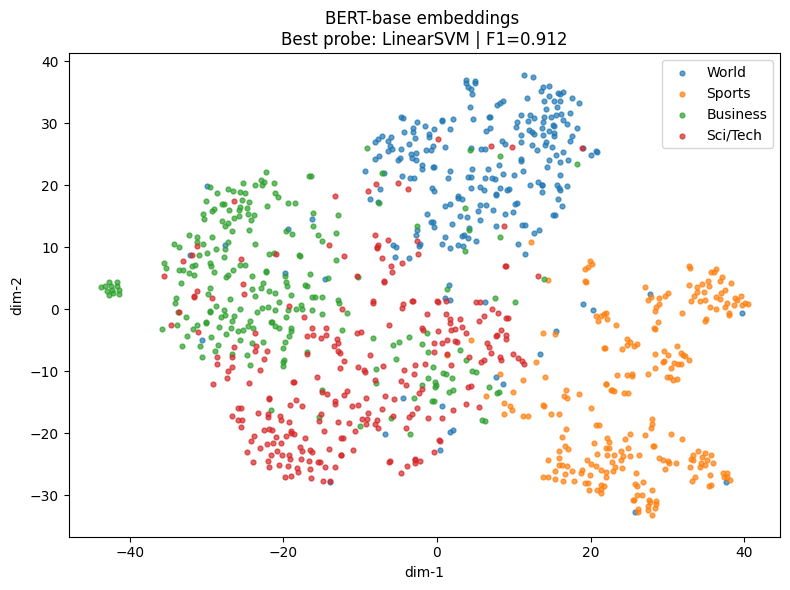


=== RoBERTa-base (roberta-base) ===


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best probe: LinearSVM | F1-macro=0.9140 | Acc=0.9141


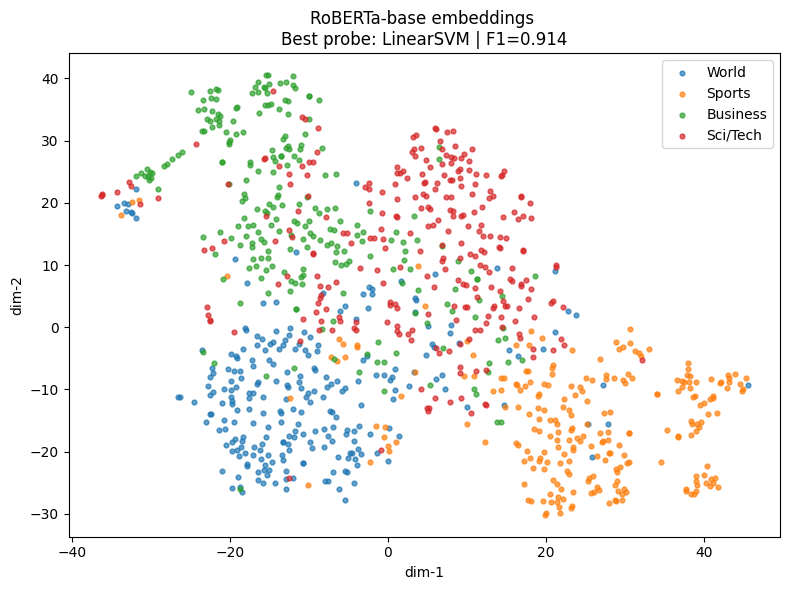


=== Summary ===
          Model Best_Probe  Test_Acc  Test_F1_macro  Emb_Dim  Train_N  Test_N
0  RoBERTa-base  LinearSVM  0.914079       0.913952      768   120000    7600
1     BERT-base  LinearSVM  0.911974       0.911820      768   120000    7600
2        MiniLM  LinearSVM  0.895789       0.895594      384   120000    7600


In [ ]:
model_candidates = {
    "MiniLM": "sentence-transformers/all-MiniLM-L6-v2",
    "BERT-base": "bert-base-uncased",
    "RoBERTa-base": "roberta-base",
}

rows = []
for label, model_name in model_candidates.items():
    row = run_one_model(
        model_label=label,
        model_name=model_name,
        X_train_texts=X_train_texts, y_train=y_train,
        X_test_texts=X_test_texts,   y_test=y_test,
        save_dir="figs",
        sub_n_tsne=1000
    )
    rows.append(row)

summary_df = pd.DataFrame(rows).sort_values("Test_F1_macro", ascending=False, ignore_index=True)
print("\n=== Summary ===")
print(summary_df)